In [1]:
import numpy as np
import torch
from torch import nn

import nflows
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.coupling import AdditiveCouplingTransform
from nflows.transforms.base import CompositeTransform
import matplotlib.pyplot as plt

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
T, L = 8, 8
lattice_shape = (T,L)
phi_ex1 = np.random.normal(size=lattice_shape).astype(np.float32)
phi_ex2 = np.random.normal(size=lattice_shape).astype(np.float32)
cfgs = torch.from_numpy(np.stack((phi_ex1, phi_ex2), axis=0))

In [4]:
def grab(var):
    return var.detach().cpu().numpy()

In [5]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape

    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)

    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

In [6]:
class ScalarPhi4Action:
    def __init__(self, M2, lam):
        self.M2 = M2
        self.lam = lam

    def __call__(self, cfgs):
        # potential term
        action_density = self.M2*cfgs**2 + self.lam*cfgs**4
        
        # kinetic term (discrete Laplacian)
        Nd = len(cfgs.shape)-1
        dims = range(1,Nd+1)
        for mu in dims:
            action_density += 2*cfgs**2
            action_density -= cfgs*torch.roll(cfgs, -1, mu)
            action_density -= cfgs*torch.roll(cfgs, 1, mu)

        return torch.sum(action_density, dim=tuple(dims))

In [7]:
ScalarPhi4Action(M2=1.0, lam=1.0)(cfgs)

tensor([544.0845, 607.1880])

In [8]:
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

In [9]:
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

In [10]:
torch_z = prior.sample_n(1024)
z = grab(torch_z)
print(f'z.shape = {z.shape}')

z.shape = (1024, 8, 8)


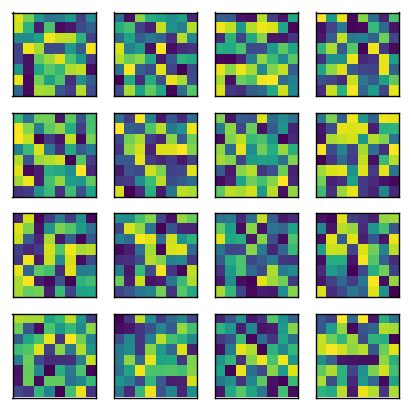

In [11]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

### Define flow in nflows

In [12]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker

In [13]:
make_checker_mask(lattice_shape, 0)

tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)

In [14]:
make_checker_mask(lattice_shape, 1)

tensor([[1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1]], dtype=torch.uint8)

In [15]:
class Net(nn.Module):
    def __init__(self, num_id, num_trf) -> None:
        super().__init__()
        mid_dim=100
        nblocks=4

        self.net = nn.Sequential(
            nn.Linear(num_id, mid_dim),
            nn.Tanh(),
            nn.Sequential(*[
                nn.Sequential(
                    nn.Linear(mid_dim, mid_dim),
                    nn.Tanh(),
                ) for _ in range(nblocks)
            ]),
            nn.Linear(mid_dim, num_trf)
        )
    
    def forward(self, x, ctx):
        return self.net(x)

In [16]:
q = prior.sample_n(1)
q.shape

torch.Size([1, 8, 8])

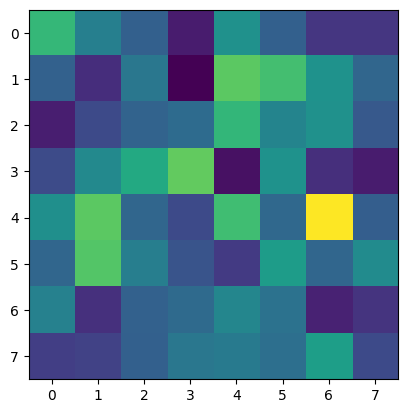

In [17]:
plt.imshow(q.squeeze())

In [18]:
def make_mask(lattice_shape, parity):
    """
    Input: B x T, flattened 8*8
    """
    mask = make_checker_mask(lattice_shape, parity)
    return mask.flatten()

In [19]:
make_mask(lattice_shape, 0)

tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0], dtype=torch.uint8)

In [20]:
num_layers = 10
base_dist = StandardNormal(shape=[64])

transforms = []
for i in range(num_layers):
    transforms.append(
        AdditiveCouplingTransform(
            make_mask(lattice_shape, i % 2), 
            Net
        ),
    )
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
flow = flow.to(device)

In [21]:
a, b = flow.sample_and_log_prob(5)

In [22]:
a.shape, b.shape

(torch.Size([5, 64]), torch.Size([5]))

### Training

In [23]:
def calc_dkl(logp, logq):
    return (logq - logp).mean() 

In [24]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg

In [25]:
def print_metrics(history, avg_last_N_epochs, epoch):
    print(f'== Era {"era"} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key} {avgd:g}')

In [26]:
def train_step(model, action, optimizer, batch_size):
    
    optimizer.zero_grad()
    # x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
    x, logq = model.sample_and_log_prob(batch_size)
    logp = -action(x)
    loss = calc_dkl(logp, logq)
    loss.backward()
    optimizer.step()
    
    print("loss", grab(loss))
    # print("logp", grab(logp))
    # print("logq", grab(logq))
    # print("ess", grab( compute_ess(logp, logq) ))
    
    # metrics['loss'].append(grab(loss))
    # metrics['logp'].append(grab(logp))
    # metrics['logq'].append(grab(logq))
    # metrics['ess'].append(grab( compute_ess(logp, logq) ))

In [27]:
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-5)
for epoch in range(10_000):
    train_step(flow, phi4_action, optimizer, 15_000)

loss 1402.3458
loss 1399.7373
loss 1400.4027
loss 1401.84
loss 1389.9512
loss 1393.5851


loss 1395.0997
loss 1390.7542
loss 1392.928
loss 1398.2507
loss 1394.5306
loss 1396.4172
loss 1392.9026
loss 1394.3894
loss 1396.9395
loss 1388.9308
loss 1385.9989
loss 1388.24
loss 1395.1576
loss 1382.8328
loss 1395.9651
loss 1393.6781
loss 1382.5752
loss 1391.0872
loss 1383.9747
loss 1383.6477
loss 1377.7828
loss 1380.905
loss 1377.684
loss 1393.429
loss 1378.2949
loss 1386.024
loss 1374.1536
loss 1385.9576
loss 1375.3027
loss 1368.9622
loss 1375.3065
loss 1380.2134
loss 1376.013
loss 1369.0178
loss 1377.6101
loss 1361.9327
loss 1367.5669
loss 1368.6814
loss 1375.0509
loss 1367.0281
loss 1373.3082
loss 1374.9829
loss 1370.1848
loss 1367.9
loss 1370.547
loss 1370.3246
loss 1370.3649
loss 1372.3187
loss 1367.6388
loss 1366.0872
loss 1366.9392
loss 1364.7673
loss 1362.1094
loss 1360.399
loss 1366.0752
loss 1364.218
loss 1366.5475
loss 1362.6989
loss 1362.25
loss 1363.5115
loss 1358.9777
loss 1362.138
loss 1357.0054
loss 1357.6576
loss 1362.3119
loss 1365.364
loss 1359.2155
loss 1359.131

KeyboardInterrupt: 